# 3) Using Pitchfork
Here's where I'm going to chuck the other cool stuff you can do with `pitchfork` that isn't necessary in the main sampler!

This is why I chose to structure the functions in this repo around importing pitchfork within the notebook first, and then passing it to `pitchfork_sampler` - this way, it shows how you can import and use the emulator directly.

I'll give a couple of rough examples of using pitchfork here:
1. Making predictions with `pitchfork.predict`
2. Emulating densely sampled stellar evolutionary tracks
3. Posterior predictive check

In [1]:
import numpy as np
import json
import corner
import matplotlib.pyplot as plt
import time
import pickle

from scripts import pitchfork_compile, pitchfork_sampler, posterior_plot

### compile pitchfork

with open('pitchfork/pitchfork.json', 'r') as fp:
    pitchfork_dict = json.load(fp)

with open('pitchfork/pitchfork_info.json', 'r') as fp:
    pitchfork_info = json.load(fp)

pitchfork_cov = np.loadtxt('pitchfork/pitchfork_covariance.txt')

pitchfork = pitchfork_compile(pitchfork_dict, pitchfork_info)

## 1. Predicting with `pitchfork`
Making predictions with `pitchfork` is super easy once imported like I've done above!

Pitchfork expects inputs with dimensions (n, 5), where n is the batch size (which can be extremely large!). This is important - `pitchfork` will complaing if you try to predict on a single point with dimension (5) - you need to make sure it has dimensions (1,5).

The 5 inputs are `['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']` *IN THAT ORDER*! This is also very important - `pitchfork` will **NOT** complain if you mix up your inputs and will confidently give a prediction with no warning.

### 1.1. Single Prediction
Let's see how we'd make a prediction for a single point with pitchfork:

In [2]:
single_point_dict = {'initial_mass': 1,
'initial_Zinit': 0.01,
'initial_Yinit': 0.26,
'initial_MLT': 2.12,
'star_age': 4.52,
}

single_point_array = np.array(list(single_point_dict.values()))

print(f"single_point_array has dimensions: {single_point_array.shape} - pitchfork won't like that...")

single_point_array_fixed = np.array([list(single_point_dict.values())])

print(f"single_point_array_fixed has dimensions: {single_point_array_fixed.shape} - much better!")

print('')
print('Passing to pitchfork to predict:')
pitchfork.predict(single_point_array_fixed)

single_point_array has dimensions: (5,) - pitchfork won't like that...
single_point_array_fixed has dimensions: (1, 5) - much better!

Passing to pitchfork to predict:


array([[ 5.96402833e+03,  1.29754341e+00, -2.05475941e-01,
         8.80108854e+02,  1.01078604e+03,  1.14147979e+03,
         1.27057330e+03,  1.39667579e+03,  1.51991572e+03,
         1.64173954e+03,  1.76369731e+03,  1.88600309e+03,
         2.00788326e+03,  2.12897460e+03,  2.24987326e+03,
         2.37142609e+03,  2.49386621e+03,  2.61684710e+03,
         2.74001038e+03,  2.86322795e+03,  2.98660627e+03,
         3.11024491e+03,  3.23413122e+03,  3.35834086e+03,
         3.48302568e+03,  3.60790458e+03,  3.73232058e+03,
         3.85589422e+03,  3.97881380e+03,  4.10131229e+03,
         4.22308059e+03,  4.34324997e+03,  4.46091616e+03,
         4.57587309e+03,  4.68897294e+03,  4.80179457e+03,
         4.91588350e+03,  5.03217627e+03]])

This looks a little convoluted, but actually this can easily be done on one line, like:
```
pitchfork.predict([[1,2,3,4,5]])
```
works absolutely fine - the important thing is to remember the extra `[]` to add the batch dimension that `pitchfork` expects.

The outputs from `pitchfork` have dimensions (n,39), with the second dimension being the 39 different outputs that `pitchfork` was trained to predict. These are:
```
["calc_effective_T", "luminosity", "star_feh"] + [f"nu_0_{i}" for i in range(6, 41)]
```
*! In that order !*

Given how well neural networks like `pitchfork` scale to huge batch sizes though (we'll see just how well later on), it's rare that we'd want to predict on just one point at a time.

### 1.2. Batched prediction
Let's see how we'd predict on a large batch of n=10,000 points each with the same input values that we used before:

In [4]:
single_point_dict = {'initial_mass': 1,
'initial_Zinit': 0.01,
'initial_Yinit': 0.26,
'initial_MLT': 2.12,
'star_age': 4.52,
}

single_point_array = np.array(list(single_point_dict.values()))

batched_points = np.full((10_000,5),single_point_array)

batched_points

array([[1.  , 0.01, 0.26, 2.12, 4.52],
       [1.  , 0.01, 0.26, 2.12, 4.52],
       [1.  , 0.01, 0.26, 2.12, 4.52],
       ...,
       [1.  , 0.01, 0.26, 2.12, 4.52],
       [1.  , 0.01, 0.26, 2.12, 4.52],
       [1.  , 0.01, 0.26, 2.12, 4.52]], shape=(10000, 5))

our `batched_points` array already has dimensions (n, 5), so we can just pass this directly to `pitchfork`!

In [5]:
pitchfork.predict(batched_points)

array([[ 5.96402833e+03,  1.29754341e+00, -2.05475941e-01, ...,
         4.80179457e+03,  4.91588350e+03,  5.03217627e+03],
       [ 5.96402833e+03,  1.29754341e+00, -2.05475941e-01, ...,
         4.80179457e+03,  4.91588350e+03,  5.03217627e+03],
       [ 5.96402833e+03,  1.29754341e+00, -2.05475941e-01, ...,
         4.80179457e+03,  4.91588350e+03,  5.03217627e+03],
       ...,
       [ 5.96402833e+03,  1.29754341e+00, -2.05475941e-01, ...,
         4.80179457e+03,  4.91588350e+03,  5.03217627e+03],
       [ 5.96402833e+03,  1.29754341e+00, -2.05475941e-01, ...,
         4.80179457e+03,  4.91588350e+03,  5.03217627e+03],
       [ 5.96402833e+03,  1.29754341e+00, -2.05475941e-01, ...,
         4.80179457e+03,  4.91588350e+03,  5.03217627e+03]],
      shape=(10000, 38))

Easy! And that certainly didn't seem 10,000 times slower than the prediction on the single point.

Let's see just how much faster *per point* a neural network is at predicting if points are batched like this.

### 1.3. Prediction timing
I'm just going to copy the code from above here, and time just the *pitchfork.predict* line for the single and batched cases.

Single point:

In [6]:
single_point_dict = {'initial_mass': 1,
'initial_Zinit': 0.01,
'initial_Yinit': 0.26,
'initial_MLT': 2.12,
'star_age': 4.52,
}

single_point_array_fixed = np.array([list(single_point_dict.values())])

single_point_start_time = time.perf_counter()
pitchfork.predict(single_point_array_fixed)
single_point_elapsed_time = time.perf_counter() - single_point_start_time

print(f"Done! Prediction for a single point took: {single_point_elapsed_time*1000:.3f}ms")

Done! Prediction for a single point took: 0.714ms


And now for the batched case:

In [7]:
single_point_dict = {'initial_mass': 1,
'initial_Zinit': 0.01,
'initial_Yinit': 0.26,
'initial_MLT': 2.12,
'star_age': 4.52,
}

single_point_array = np.array(list(single_point_dict.values()))

batched_points = np.full((10_000,5),single_point_array)

batched_points_start_time = time.perf_counter()
pitchfork.predict(batched_points)
batched_points_elapsed_time = time.perf_counter() - batched_points_start_time

print(f"Done! Prediction on {len(batched_points)} points took: {batched_points_elapsed_time:.3f}s")

Done! Prediction on 10000 points took: 0.134s


Let's see whether prediction for the batch of 10,000 points was 10,000 times slower than for the single point:

In [8]:
print(f'Batch of {len(batched_points)} took {batched_points_elapsed_time/single_point_elapsed_time:.0f} times as long as for the single point.' )

Batch of 10000 took 188 times as long as for the single point.


Nice! This shows why `pitchfork` is so well suited for a Bayesian inference pipeline that allows for vectorised likelihood evaluation like `UltraNest` :)

## 2. Emulating an evolutionary track
One neat thing about using an emulator rather than modelling on-the-fly is that we don't have to worry about the forward modelling dependance (tracks being evolved from zero age forwards in consecutive steps of age).

And, given we can emulate batches of many points extremely quickly, we can emulate an arbitrarily dense evolutionary track for a given set of fundamental properties nearly instantly!

Let's make a function to do that for us:

In [116]:
def emulate_track(pitchfork, initial_mass, initial_Zinit, initial_Yinit, initial_MLT, n_points=100_000, min_age = 0.03, max_age = 10):
    fundamental_params = [initial_mass, initial_Zinit, initial_Yinit, initial_MLT]
    
    zero_age_point = np.array(fundamental_params+[0])

    track = np.full((n_points,5), zero_age_point)

    ages = np.linspace(min_age, max_age, n_points)

    track[:,4] = ages

    emulated_track = pitchfork.predict(track)

    emulated_teff = emulated_track[:,0]
    
    emulated_L = emulated_track[:,1]
    
    plt.scatter(emulated_teff, np.log10(emulated_L), c=ages, s=8, cmap = 'winter')
    cbar = plt.colorbar()
    plt.gca().invert_xaxis()
    plt.xlabel(r'$T_{\text{eff}},\,\text{K}$')
    
    plt.ylabel(r'$\text{log}L, \text{dex}$')
    cbar.set_label('Age, Gyr')

    plt.show()
    

and now we can try to emulate a sparse track with just 100 evenly spaced points in age:

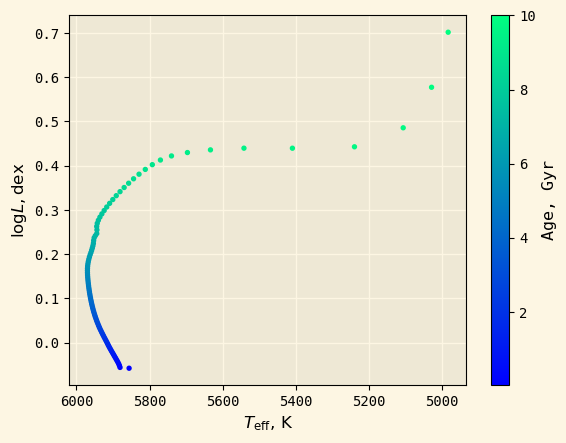

In [117]:
emulate_track(pitchfork, 1, 0.01, 0.26, 2.12, n_points=100)

or a densely sampled track with 100,000 points in age:

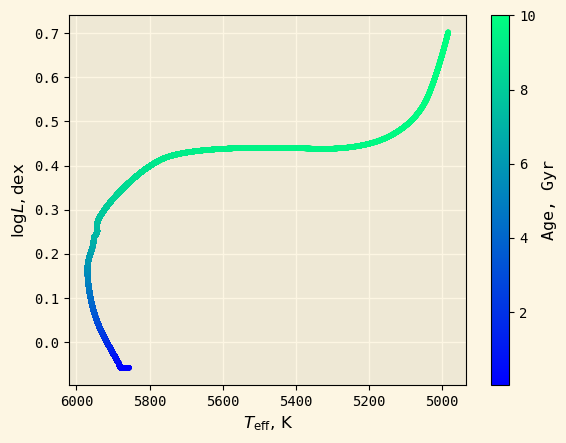

In [118]:
emulate_track(pitchfork, 1, 0.01, 0.26, 2.12, n_points=100_000)

And we can easily change the input values and try again - what about a star right at the upper limit of `pitchfork`'s trained range:

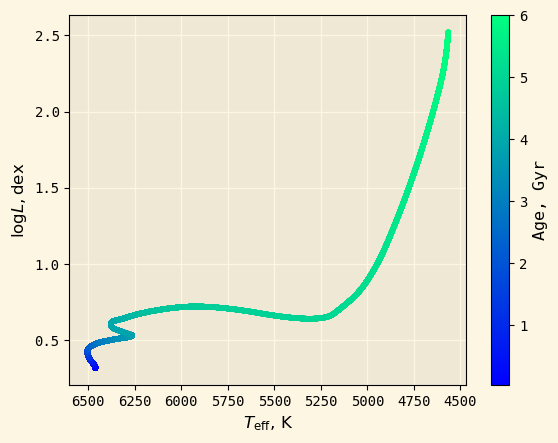

In [119]:
emulate_track(pitchfork, 1.2, 0.01, 0.26, 2.12, max_age = 6, n_points=100_000)

## 3. Posterior Predictive Check
Another cool thing we can do with `pitchfork` is a posterior predictive check!

When we've run our `pitchfork` sampler, we end up with posterior samples in the input domain for `pitchfork` (i.e. `['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']`).

Even though our posteriors can contain thousands of samples, we've demonstrated above that `pitchfork` can make a prediction on all of these in milliseconds!

The result are posterior predicted observables for each set of posterior samples, which we can then use to make sure our posterior predicted observables do actually match up with the data used to sample the posterior in the first place.

Let's take a quick look at how we could get some posterior predictions from saved solar data and sampling results:

In [24]:
with open('stars/Sun/Sun.json', 'r') as fp:
    Sun_data = json.load(fp)

with open('stars/Sun/Sun_results.pkl', 'rb') as fp:
    Sun_samples = pickle.load(fp)['samples']

Sun_input_samples = Sun_samples[:,:5]

posterior_preds = pitchfork.predict(Sun_input_samples)

Done! Now to perform our posterior predictive check we can compare to the data used by plotting like so (I crop to just n=22 to keep corner dimensions down):

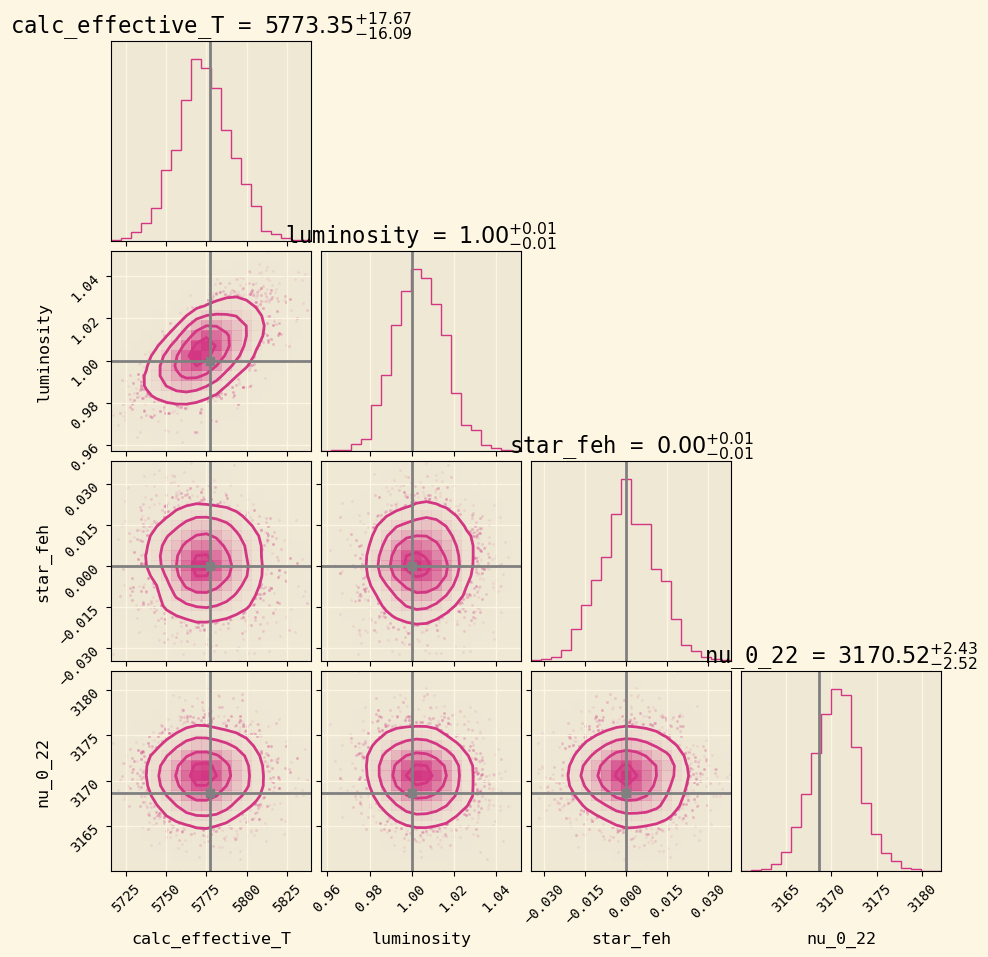

In [25]:
labels = ["calc_effective_T", "luminosity", "star_feh", 'nu_0_22']

truths = [Sun_data[label][0] for label in labels]

cropped_posterior_preds = np.column_stack((posterior_preds[:,:3], posterior_preds[:,19]))
fig = corner.corner(cropped_posterior_preds, labels=labels, color='#D33682', smooth=True, truths=truths, show_titles = True, truth_color = 'gray')

Pretty good! You may notice that our posterior predictive distribution for n=22 is slightly off - but this is expected!

Check the paper for the gritty details, but basically there is a "surface correction" that must be applied to simulated (and therefore emulated) mode frequencies for them to match observed modes which comes from our inability to properly model the near-surface layers of the star.

This is what the `a` and `b` parameters that we sample for - they parameterise the surface correction. Again, I won't go into too much detail here, but here's a repeated posterior predictive check with the sampled `a` and `b` used to correct the posterior predicted mode frequencies:

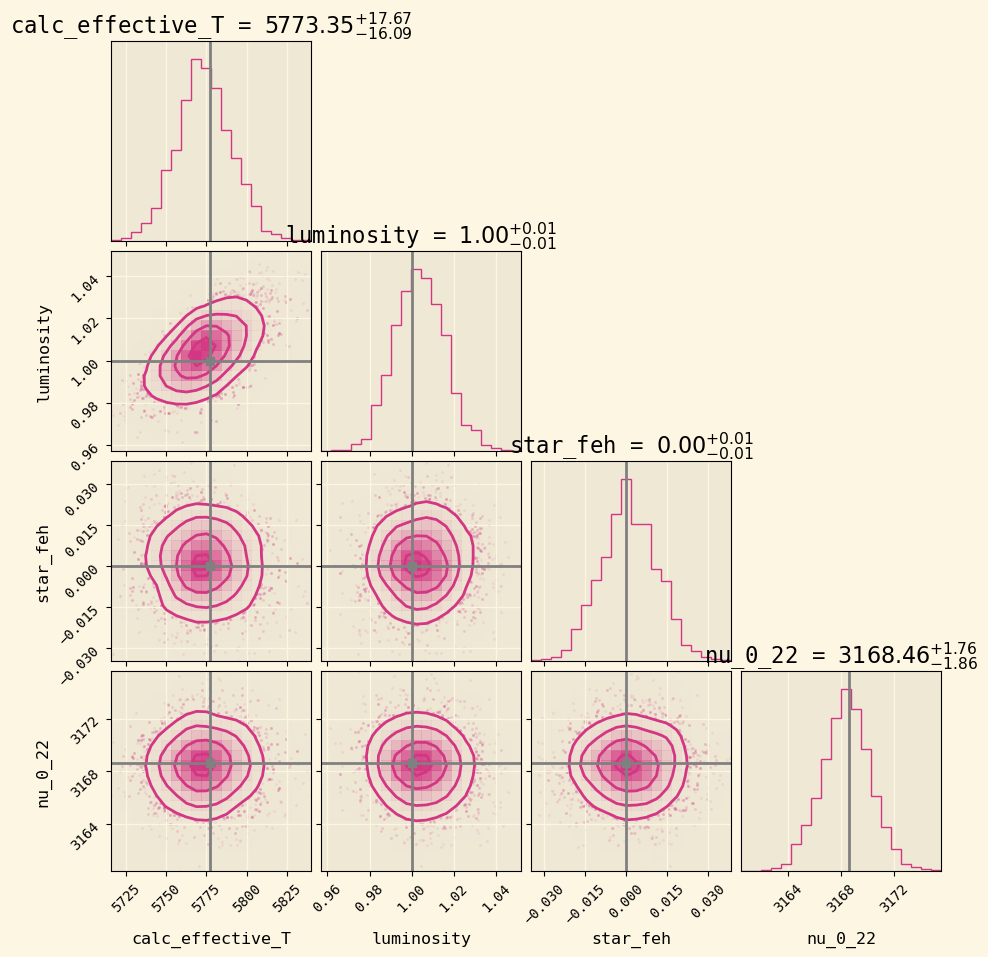

In [34]:
def surface_correction(freq_arr, a_arr, b_arr, nu_max):
    return freq_arr + a_arr*((freq_arr/nu_max)**b_arr)

a_arr = np.expand_dims(Sun_samples[:,5],1)
b_arr = np.expand_dims(Sun_samples[:,6],1)

nu_max = Sun_data['nu_max'][0]

freq_array = posterior_preds[:,3:]

corrected_freq_array = surface_correction(freq_array, a_arr, b_arr, nu_max)

corrected_posterior_preds = np.concatenate((posterior_preds[:,:3], corrected_freq_array), axis=1)

cropped_corrected_posterior_preds = np.column_stack((corrected_posterior_preds[:,:3], corrected_posterior_preds[:,19]))

fig = corner.corner(cropped_corrected_posterior_preds, labels=labels, color='#D33682', smooth=True, truths=truths, show_titles = True, truth_color = 'gray')

Nice :)